# Transfer Learning for Image Classification

This notebook demonstrates fine-tuning a pre-trained ResNet50 model on a custom dataset.

## Overview
- Load pre-trained ResNet50 from PyTorch
- Adapt final layers for custom classification task
- Apply data augmentation
- Train on small dataset (≤10k images)
- Evaluate performance with metrics and visualizations

## 1. Setup and Imports

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torchvision
from torchvision import datasets, models, transforms

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from tqdm import tqdm
import os
from pathlib import Path

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cpu


## 2. Configuration

In [2]:
# Hyperparameters
CONFIG = {
    'batch_size': 32,
    'num_epochs': 10,
    'learning_rate': 0.001,
    'num_classes': 5,  # Adjust based on your dataset
    'train_split': 0.8,
    'image_size': 224,
    'num_workers': 2,
}

# Dataset path - using PyTorch built-in dataset for demo
# Replace with your custom dataset path: data_dir = 'path/to/your/dataset'
data_dir = './data'  # Images should be organized in subfolders by class

## 3. Data Augmentation and Preprocessing

Data augmentation helps prevent overfitting on small datasets by creating variations of training images.

In [3]:
# Data augmentation for training
train_transforms = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Validation/test transforms (no augmentation)
val_transforms = transforms.Compose([
    transforms.Resize((CONFIG['image_size'], CONFIG['image_size'])),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

print("Data transforms configured successfully")

Data transforms configured successfully


## 4. Load Dataset

For demonstration, we'll use the Flowers102 dataset. Replace this with your custom dataset.

**Custom Dataset Structure:**
```
data/
├── class1/
│   ├── img1.jpg
│   ├── img2.jpg
│   └── ...
├── class2/
│   └── ...
└── classN/
    └── ...
```

In [4]:
# For demo: Download Flowers102 dataset
# For custom dataset, use: dataset = datasets.ImageFolder(data_dir, transform=train_transforms)

try:
    # Try loading custom dataset
    full_dataset = datasets.ImageFolder(data_dir, transform=train_transforms)
    num_classes = len(full_dataset.classes)
    class_names = full_dataset.classes
    print(f"Loaded custom dataset with {len(full_dataset)} images")
    print(f"Number of classes: {num_classes}")
    print(f"Classes: {class_names}")
except:
    # Fallback to demo dataset
    print("Custom dataset not found. Using Flowers102 for demonstration.")
    print("Downloading dataset...")
    full_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=train_transforms)
    num_classes = 102
    class_names = [f'class_{i}' for i in range(num_classes)]
    print(f"Loaded Flowers102 dataset with {len(full_dataset)} images")

# Update config with actual number of classes
CONFIG['num_classes'] = num_classes

# Split into train and validation sets
train_size = int(CONFIG['train_split'] * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

# Apply validation transforms to validation set
val_dataset.dataset.transform = val_transforms

print(f"\nTrain set: {len(train_dataset)} images")
print(f"Validation set: {len(val_dataset)} images")

Custom dataset not found. Using Flowers102 for demonstration.


100%|██████████| 345M/345M [00:06<00:00, 55.3MB/s] 
100%|██████████| 502/502 [00:00<00:00, 3.52MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 53.0MB/s]


Loaded Flowers102 dataset with 1020 images

Train set: 816 images
Validation set: 204 images


## 5. Create Data Loaders

In [5]:
train_loader = DataLoader(
    train_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=True,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

val_loader = DataLoader(
    val_dataset,
    batch_size=CONFIG['batch_size'],
    shuffle=False,
    num_workers=CONFIG['num_workers'],
    pin_memory=True if torch.cuda.is_available() else False
)

print(f"Created data loaders with batch size: {CONFIG['batch_size']}")
print(f"Training batches: {len(train_loader)}")
print(f"Validation batches: {len(val_loader)}")

Created data loaders with batch size: 32
Training batches: 26
Validation batches: 7


## 6. Visualize Sample Images

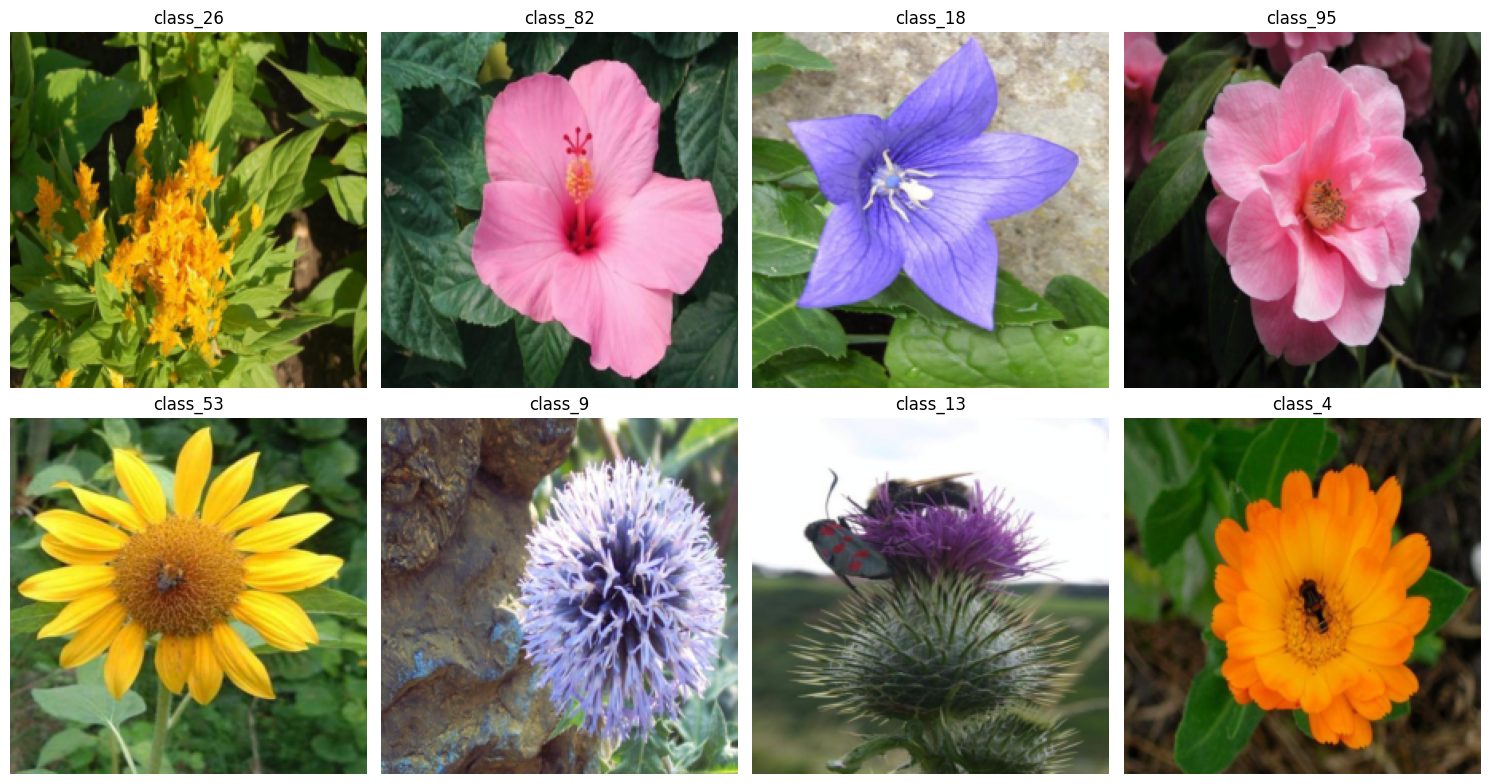

In [6]:
def imshow(img, title=None):
    """Display image with denormalization."""
    img = img.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    if title:
        plt.title(title)
    plt.axis('off')

# Get a batch of training data
images, labels = next(iter(train_loader))

# Display first 8 images
fig = plt.figure(figsize=(15, 8))
for idx in range(min(8, len(images))):
    ax = fig.add_subplot(2, 4, idx + 1)
    imshow(images[idx])
    if len(class_names) > labels[idx]:
        ax.set_title(f'{class_names[labels[idx]]}')
    else:
        ax.set_title(f'Class {labels[idx]}')
plt.tight_layout()
plt.show()

## 7. Load Pre-trained Model and Adapt Final Layers

We use ResNet50 pre-trained on ImageNet and modify the final fully connected layer for our specific classification task.

In [7]:
# Load pre-trained ResNet50
model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)

print(f"Original ResNet50 final layer: {model.fc}")

# Freeze all layers except the final classifier
for param in model.parameters():
    param.requires_grad = False

# Replace final fully connected layer
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 512),
    nn.ReLU(),
    nn.Dropout(0.3),
    nn.Linear(512, CONFIG['num_classes'])
)

print(f"\nModified final layer: {model.fc}")

# Move model to device
model = model.to(device)

# Count trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in model.parameters())
print(f"\nTrainable parameters: {trainable_params:,} / {total_params:,} ({100*trainable_params/total_params:.2f}%)")

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to C:\Users\EG/.cache\torch\hub\checkpoints\resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 117MB/s]


Original ResNet50 final layer: Linear(in_features=2048, out_features=1000, bias=True)

Modified final layer: Sequential(
  (0): Linear(in_features=2048, out_features=512, bias=True)
  (1): ReLU()
  (2): Dropout(p=0.3, inplace=False)
  (3): Linear(in_features=512, out_features=102, bias=True)
)

Trainable parameters: 1,101,414 / 24,609,446 (4.48%)


## 8. Define Loss Function and Optimizer

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=CONFIG['learning_rate'])
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2)

print(f"Loss function: {criterion}")
print(f"Optimizer: {optimizer}")
print(f"Learning rate scheduler: ReduceLROnPlateau")

TypeError: ReduceLROnPlateau.__init__() got an unexpected keyword argument 'verbose'

## 9. Training Loop

In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    pbar = tqdm(dataloader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)
        
        # Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc


def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        pbar = tqdm(dataloader, desc='Validation')
        for images, labels in pbar:
            images, labels = images.to(device), labels.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({'loss': loss.item(), 'acc': 100 * correct / total})
    
    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
# Training history
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

best_val_acc = 0.0

print(f"Starting training for {CONFIG['num_epochs']} epochs...\n")

for epoch in range(CONFIG['num_epochs']):
    print(f"\nEpoch {epoch+1}/{CONFIG['num_epochs']}")
    print("-" * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    
    # Validate
    val_loss, val_acc = validate_epoch(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    # Learning rate scheduling
    scheduler.step(val_loss)
    
    print(f"\nTrain Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    
    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_model.pth')
        print(f"✓ Saved best model with validation accuracy: {val_acc:.2f}%")

print("\n" + "="*50)
print(f"Training completed! Best validation accuracy: {best_val_acc:.2f}%")
print("="*50)

## 10. Visualize Training History

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot loss
ax1.plot(history['train_loss'], label='Train Loss', marker='o')
ax1.plot(history['val_loss'], label='Val Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot accuracy
ax2.plot(history['train_acc'], label='Train Acc', marker='o')
ax2.plot(history['val_acc'], label='Val Acc', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Validation Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

## 11. Load Best Model and Evaluate

In [ ]:
# Load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

print("Loaded best model for evaluation")

## 12. Generate Predictions and Calculate Metrics

In [ ]:
def get_predictions(model, dataloader, device):
    """Get all predictions and true labels."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    
    with torch.no_grad():
        for images, labels in tqdm(dataloader, desc='Predicting'):
            images = images.to(device)
            outputs = model(images)
            probs = torch.softmax(outputs, dim=1)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
            all_probs.extend(probs.cpu().numpy())
    
    return np.array(all_preds), np.array(all_labels), np.array(all_probs)

# Get predictions
predictions, true_labels, probabilities = get_predictions(model, val_loader, device)

# Calculate accuracy
accuracy = accuracy_score(true_labels, predictions)
print(f"\nValidation Accuracy: {accuracy * 100:.2f}%")

## 13. Confusion Matrix

In [ ]:
# Compute confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names[:CONFIG['num_classes']], 
            yticklabels=class_names[:CONFIG['num_classes']],
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Normalized confusion matrix
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(12, 10))
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names[:CONFIG['num_classes']], 
            yticklabels=class_names[:CONFIG['num_classes']],
            cbar_kws={'label': 'Proportion'})
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Normalized Confusion Matrix')
plt.tight_layout()
plt.savefig('confusion_matrix_normalized.png', dpi=300, bbox_inches='tight')
plt.show()

## 14. Classification Report

In [ ]:
# Generate classification report
print("\nClassification Report:")
print("=" * 70)
report = classification_report(
    true_labels, 
    predictions, 
    target_names=class_names[:CONFIG['num_classes']],
    digits=4
)
print(report)

## 15. Analyze Misclassifications

Let's examine cases where the model made incorrect predictions.

In [ ]:
# Find misclassified samples
misclassified_indices = np.where(predictions != true_labels)[0]
print(f"Total misclassifications: {len(misclassified_indices)} / {len(true_labels)} ({100*len(misclassified_indices)/len(true_labels):.2f}%)")

# Get confidence scores for misclassifications
misclassified_confidences = []
for idx in misclassified_indices:
    pred_class = predictions[idx]
    confidence = probabilities[idx][pred_class]
    misclassified_confidences.append(confidence)

print(f"\nAverage confidence in wrong predictions: {np.mean(misclassified_confidences):.4f}")
print(f"Min confidence: {np.min(misclassified_confidences):.4f}")
print(f"Max confidence: {np.max(misclassified_confidences):.4f}")

In [ ]:
# Visualize misclassified samples
def visualize_misclassifications(dataset, indices, predictions, true_labels, probabilities, class_names, num_samples=12):
    """Visualize misclassified samples."""
    num_samples = min(num_samples, len(indices))
    if num_samples == 0:
        print("No misclassifications to display!")
        return
    
    # Select random misclassified samples
    selected_indices = np.random.choice(indices, size=num_samples, replace=False)
    
    fig = plt.figure(figsize=(20, 15))
    for i, idx in enumerate(selected_indices):
        # Get image
        img, _ = dataset[idx]
        
        pred_class = predictions[idx]
        true_class = true_labels[idx]
        confidence = probabilities[idx][pred_class] * 100
        
        ax = fig.add_subplot(3, 4, i + 1)
        imshow(img)
        
        # Create title with prediction info
        true_name = class_names[true_class] if true_class < len(class_names) else f'Class {true_class}'
        pred_name = class_names[pred_class] if pred_class < len(class_names) else f'Class {pred_class}'
        
        ax.set_title(
            f'True: {true_name}\nPred: {pred_name}\nConf: {confidence:.1f}%',
            fontsize=10, color='red'
        )
    
    plt.tight_layout()
    plt.savefig('misclassifications.png', dpi=300, bbox_inches='tight')
    plt.show()

# Visualize misclassifications
visualize_misclassifications(
    val_dataset.dataset,
    misclassified_indices,
    predictions,
    true_labels,
    probabilities,
    class_names,
    num_samples=12
)

## 16. Per-Class Performance Analysis

In [ ]:
# Calculate per-class accuracy
per_class_correct = []
per_class_total = []
per_class_acc = []

for class_idx in range(CONFIG['num_classes']):
    class_mask = true_labels == class_idx
    class_preds = predictions[class_mask]
    class_true = true_labels[class_mask]
    
    correct = np.sum(class_preds == class_true)
    total = len(class_true)
    accuracy = correct / total if total > 0 else 0
    
    per_class_correct.append(correct)
    per_class_total.append(total)
    per_class_acc.append(accuracy)

# Plot per-class accuracy
plt.figure(figsize=(15, 6))
x_pos = np.arange(CONFIG['num_classes'])
plt.bar(x_pos, per_class_acc, alpha=0.7, color='steelblue')
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Per-Class Accuracy')
plt.xticks(x_pos, [class_names[i] if i < len(class_names) else f'C{i}' for i in range(CONFIG['num_classes'])], rotation=45, ha='right')
plt.axhline(y=accuracy, color='r', linestyle='--', label=f'Overall Acc: {accuracy:.3f}')
plt.legend()
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.savefig('per_class_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary
print("\nPer-Class Performance:")
print("=" * 70)
for i in range(CONFIG['num_classes']):
    class_name = class_names[i] if i < len(class_names) else f'Class {i}'
    print(f"{class_name:25s}: {per_class_acc[i]*100:6.2f}% ({per_class_correct[i]:3d}/{per_class_total[i]:3d})")

## 17. Model Summary and Statistics

In [ ]:
print("\n" + "="*70)
print("MODEL SUMMARY")
print("="*70)
print(f"Architecture: ResNet50 (Transfer Learning)")
print(f"Pre-trained on: ImageNet")
print(f"Fine-tuned for: {CONFIG['num_classes']} classes")
print(f"\nDataset Size:")
print(f"  Training samples: {len(train_dataset)}")
print(f"  Validation samples: {len(val_dataset)}")
print(f"\nTraining Configuration:")
print(f"  Epochs: {CONFIG['num_epochs']}")
print(f"  Batch size: {CONFIG['batch_size']}")
print(f"  Learning rate: {CONFIG['learning_rate']}")
print(f"  Optimizer: Adam")
print(f"  Loss function: CrossEntropyLoss")
print(f"\nModel Parameters:")
print(f"  Total parameters: {total_params:,}")
print(f"  Trainable parameters: {trainable_params:,} ({100*trainable_params/total_params:.2f}%)")
print(f"\nPerformance:")
print(f"  Best validation accuracy: {best_val_acc:.2f}%")
print(f"  Final validation accuracy: {accuracy * 100:.2f}%")
print(f"  Total misclassifications: {len(misclassified_indices)} / {len(true_labels)}")
print("="*70)

## 18. Save Model and Results

In [ ]:
# Save final model
torch.save({
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'config': CONFIG,
    'class_names': class_names,
    'history': history,
    'best_val_acc': best_val_acc
}, 'transfer_learning_model.pth')

print("Model and training history saved successfully!")
print("\nSaved files:")
print("  - best_model.pth")
print("  - transfer_learning_model.pth")
print("  - training_history.png")
print("  - confusion_matrix.png")
print("  - confusion_matrix_normalized.png")
print("  - misclassifications.png")
print("  - per_class_accuracy.png")

## Summary

This notebook demonstrated:
1. **Loading a pre-trained model**: Used ResNet50 pre-trained on ImageNet
2. **Transfer learning**: Froze convolutional layers and trained only final classifier
3. **Data augmentation**: Applied transformations to increase training data diversity
4. **Training**: Fine-tuned model on custom dataset
5. **Evaluation**: Comprehensive metrics including accuracy, confusion matrix, and misclassification analysis

### Key Observations
- Transfer learning allows achieving good performance with limited data
- Pre-trained features from ImageNet generalize well to many vision tasks
- Data augmentation helps prevent overfitting on small datasets
- Only training final layers is computationally efficient

### Next Steps
- Try unfreezing more layers for fine-tuning
- Experiment with different architectures (EfficientNet, ViT)
- Compare with training from scratch (see `comparison_notebook.ipynb`)
- Apply to your custom dataset